
<h1 align="center"><font size="5">Classification with Python</font></h1>

We try to practice all the classification algorithms that we learned in previous courses.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [15]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import wget
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |
|matrix|All confusion matrixes (Overwritten over multiple prediction methods)
|report|List for all possible arguments in SVM section and its score

Lets download the dataset

In [16]:
wget.download('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv')

100% [..............................................................................] 23101 / 23101

'loan_train.csv'

### Load Data From CSV File  

In [17]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [18]:
df.shape

(346, 10)

### Convert to date time object 

In [19]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [20]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

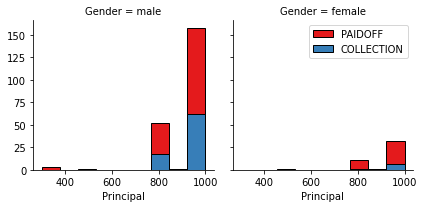

In [25]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

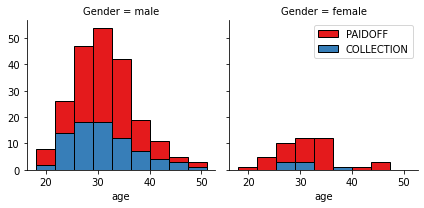

In [26]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

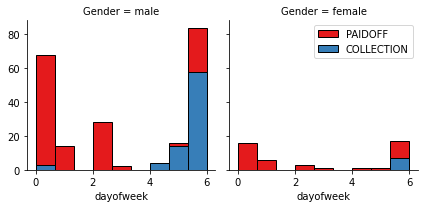

In [27]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [28]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [29]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [30]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [31]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [32]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [33]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [34]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [35]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [36]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix as cm

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

score = []

for k in range(3,15):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    score.append(classifier.score(X_test,y_test))

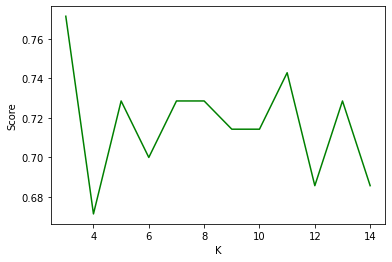

In [136]:
plt.plot(range(3,15),score,c='green')
plt.xlabel('K')
plt.ylabel('Score')

plt.show()

In [137]:
classifier = KNeighborsClassifier(n_neighbors=10).fit(X_train,y_train)

y_pred = classifier.predict(X_test)
matrix = cm(y_test,y_pred)

In [138]:
matrix
# wow nearly half of collection wrong, only reliable predictions are on the side of whether you've paid off the debt

array([[ 4, 12],
       [ 8, 46]], dtype=int64)

In [139]:
classifier.score(X_test,y_test)

0.7142857142857143

# Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
score = []
for x in range(3,8):
    dtc = DecisionTreeClassifier(max_depth=x).fit(X_train,y_train)
    
    print(f'Score={dtc.score(X_test,y_test)} for max_depth:{x}')
    score.append(dtc.score(X_test,y_test))

Score=0.6857142857142857 for max_depth:3
Score=0.6428571428571429 for max_depth:4
Score=0.6285714285714286 for max_depth:5
Score=0.6285714285714286 for max_depth:6
Score=0.6285714285714286 for max_depth:7


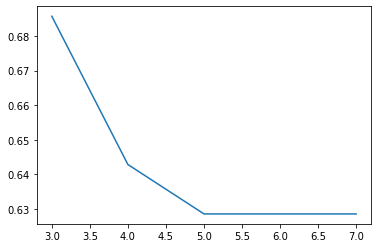

In [45]:
plt.plot(range(3,8),score)
# We shall use 4 for efficiency

In [46]:
dtc = DecisionTreeClassifier(max_depth=4).fit(X_train,y_train)
y_pred = dtc.predict(X_test)

matrix = cm(y_pred,y_test)

In [47]:
matrix

array([[ 2,  5],
       [20, 43]], dtype=int64)

In [51]:
!pip install Graphviz

In [53]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [56]:
# above error is device related, will solve if have time

In [54]:
dtc.score(X_test,y_test)

0.6428571428571429

# Support Vector Machine

In [55]:
from sklearn import svm

In [57]:
c = range(1,10)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degree = range(1,6)

report = []

for c_ in c:
  for k in kernels:
    for d in degree:
      clas = svm.SVC(C=c_,kernel=k,degree=d).fit(X_train,y_train)
      s = clas.score(X_test,y_test)
      rep = f'Score of {s} with c of {c_}, degree of {d} and in the {k} kernel'

      print(rep)
      report.append(rep)

Score of 0.6857142857142857 with c of 1, degree of 1 and in the linear kernel
Score of 0.6857142857142857 with c of 1, degree of 2 and in the linear kernel
Score of 0.6857142857142857 with c of 1, degree of 3 and in the linear kernel
Score of 0.6857142857142857 with c of 1, degree of 4 and in the linear kernel
Score of 0.6857142857142857 with c of 1, degree of 5 and in the linear kernel
Score of 0.6857142857142857 with c of 1, degree of 1 and in the poly kernel
Score of 0.6857142857142857 with c of 1, degree of 2 and in the poly kernel
Score of 0.6714285714285714 with c of 1, degree of 3 and in the poly kernel
Score of 0.7 with c of 1, degree of 4 and in the poly kernel
Score of 0.6857142857142857 with c of 1, degree of 5 and in the poly kernel
Score of 0.6857142857142857 with c of 1, degree of 1 and in the rbf kernel
Score of 0.6857142857142857 with c of 1, degree of 2 and in the rbf kernel
Score of 0.6857142857142857 with c of 1, degree of 3 and in the rbf kernel
Score of 0.685714285

In [72]:
clas = svm.SVC(C=2,kernel='sigmoid').fit(X_train,y_train)

y_pred = clas.predict(X_test)

matrix = cm(y_test,y_pred)
matrix

array([[ 6, 16],
       [14, 34]], dtype=int64)

# Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression

In [66]:
model = LogisticRegression().fit(X_train,y_train)

model.score(X_test,y_test)

0.6857142857142857

In [71]:
model.predict(X_train)

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 

In [67]:
matrix = cm(y_test,model.predict(X_test))

matrix

array([[ 0, 22],
       [ 0, 48]], dtype=int64)

In [ ]:
# Very strange, unable to understand why the result is like this

# Model Evaluation using Test set

In [98]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

First, download and load the test set:

In [76]:
wget.download('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv','loan_test.csv')

100% [................................................................................] 3642 / 3642

'loan_test.csv'

### Load Test set for evaluation 

In [156]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [190]:
Y = test_df['loan_status']

In [191]:
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [192]:
test_df.isnull().any()

Unnamed: 0        False
Unnamed: 0.1      False
loan_status       False
Principal         False
terms             False
effective_date    False
due_date          False
age               False
education         False
Gender            False
dayofweek         False
weekend           False
dtype: bool

In [193]:
# Normalising data here as well

In [194]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000.0,30.0,50.0,female,0.0,0,1,0
1,300.0,7.0,35.0,male,0.0,1,0,0
2,1000.0,30.0,43.0,female,0.0,0,0,1
3,1000.0,30.0,26.0,male,1.0,0,0,1
4,800.0,15.0,29.0,male,1.0,0,0,1


In [195]:
Feature.dropna(inplace=True)

In [196]:
Feature['Principal'] = StandardScaler().fit_transform(Feature['Principal'].values.reshape(-1,1))
Feature['terms'] = StandardScaler().fit_transform(Feature['terms'].values.reshape(-1,1))
Feature['age'] = StandardScaler().fit_transform(Feature['age'].values.reshape(-1,1))

In [197]:
Feature['Gender'].replace('female',0,inplace=True)
Feature['Gender'].replace('male',1,inplace=True)

In [198]:
Feature

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,0.493626,0.928450,3.059819,0,0.0,0,1,0
1,-3.562691,-1.704277,0.533363,1,0.0,1,0,0
2,0.493626,0.928450,1.880806,0,0.0,0,0,1
3,0.493626,0.928450,-0.982511,1,1.0,0,0,1
4,-0.665322,-0.788546,-0.477219,1,1.0,0,0,1
5,-1.244796,-0.788546,0.196502,1,1.0,0,0,1
6,0.493626,-0.788546,-1.319371,1,1.0,0,0,1
7,0.493626,0.928450,0.028072,1,1.0,0,0,1
8,-0.665322,-0.788546,-0.814080,0,1.0,0,0,1
9,0.493626,-0.788546,0.870224,1,1.0,0,1,0


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

Note: 

knn = classifier

decision tree = dtc

svm = clas

logic = model

In [201]:
scores = []
methods = [classifier,dtc,clas,model]

for each in methods:
    scores.append(each.score(Feature.values,Y))

In [206]:
scoreboard = pd.DataFrame(scores).T
scoreboard.columns = methods

In [207]:
scoreboard

,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=10, p=2,\n weights='uniform')","DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',\n max_depth=4, max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, presort='deprecated',\n random_state=None, splitter='best')","SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',\n max_iter=-1, probability=False, random_state=None, shrinking=True,\n tol=0.001, verbose=False)","LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n warm_start=False)"
0,0.574074,0.666667,0.685185,0.740741


<h2>Well Done</h2>